In [1]:
%pip install tensorflow_datasets
import pandas as pd
import numpy as np
import os
import glob

import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sn
import numpy as np
import pathlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/sihArohi/HTM/Arohi28oct/archive (2)')

In [4]:
import pathlib

train_dir = pathlib.Path('train')  # Assuming your train images are in a folder named 'train' within your project directory.
test_dir = pathlib.Path('test')    # Assuming your test images are in a folder named 'test' within your project directory.

image_count_train = len(list(train_dir.glob('*/*.jpg')))
image_count_test = len(list(test_dir.glob('*/*.jpg')))

print("Train Image Count: {}\nTest Image Count: {}".format(image_count_train, image_count_test))


Train Image Count: 2100
Test Image Count: 900


## Create DataSet

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2100 files belonging to 2 classes.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

In [11]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8
66/66 [==============================] - 204s 3s/step - loss: 0.4677 - accuracy: 0.7771 - val_loss: 0.3618 - val_accuracy: 0.8256
Epoch 2/8
66/66 [==============================] - 2s 27ms/step - loss: 0.2329 - accuracy: 0.9095 - val_loss: 0.2823 - val_accuracy: 0.8767
Epoch 3/8
66/66 [==============================] - 2s 26ms/step - loss: 0.1292 - accuracy: 0.9576 - val_loss: 0.2059 - val_accuracy: 0.9167
Epoch 4/8
66/66 [==============================] - 2s 28ms/step - loss: 0.0727 - accuracy: 0.9790 - val_loss: 0.2067 - val_accuracy: 0.9333
Epoch 5/8
66/66 [==============================] - 2s 30ms/step - loss: 0.0539 - accuracy: 0.9819 - val_loss: 0.1148 - val_accuracy: 0.9633
Epoch 6/8
66/66 [==============================] - 2s 27ms/step - loss: 0.0387 - accuracy: 0.9886 - val_loss: 0.2269 - val_accuracy: 0.9322
Epoch 7/8
66/66 [==============================] - 2s 26ms/step - loss: 0.0421 - accuracy: 0.9852 - val_loss: 0.1829 - val_accuracy: 0.9556
Epoch 8/8
66/66 [===

## Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

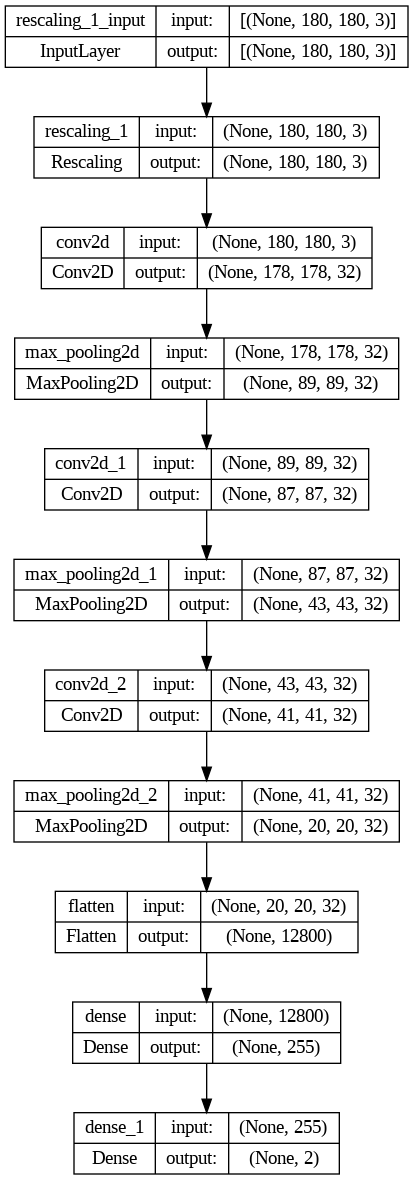

In [13]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True)

## Fit, Evaluate Model

### Visualize Results

In [14]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()
    except:
      pass

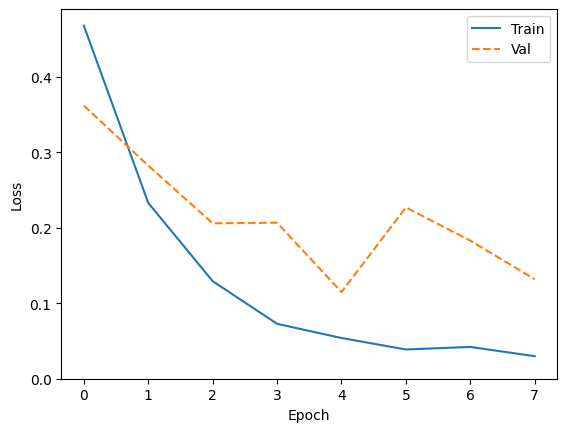

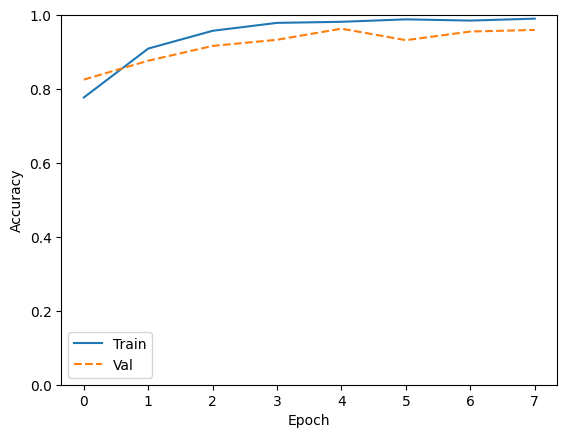

In [15]:
plot_metrics(hist)

# Model Testing on Test Data

In [16]:
def list_files(dir,full_dir):
    r = []
    r1 = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            rr = os.path.join(root, name)
            r.append(rr)
    dd = {'local_path':r}
    df = pd.DataFrame(dd)
    return df

def proccess(img1):
  img = tf.keras.preprocessing.image.load_img(
      img1, target_size=(img_height, img_width)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  pred = class_names[np.argmax(score)]
  score1 = 100 * np.max(score)

  return pred, score1

def new_col(col):
    if col['Pred'] == 'yes' and col['Actual'] == 'yes':
        return 1
    elif col['Pred'] == 'no' and col['Actual'] == 'no':
      return 1
    else:
      return 0


def proccess1(df):
    aa = []
    bb = []
    cc = []

    for _, row in df.iterrows():
        img = row['local_path']
        pred, value = proccess(img)
        pat = row['local_path']

        # Split the path using '/'
        path_parts = pat.split('/')

        # Extract the last directory as "Actual"
        actual = path_parts[-2]  # Use -2 to get the second-to-last part

        aa.append(pred)
        bb.append(value)
        cc.append(actual)

    vals = {"Pred": aa, "Accurarcy": bb, 'Actual': cc}
    df_test1 = pd.DataFrame(vals)
    df_test1 = pd.concat([df, df_test1], axis=1)

    df_test1['Check'] = df_test1.apply(lambda col: new_col(col), axis=1)

    return df_test1



In [18]:
fullpath = '/content/drive/My Drive/sihArohi/HTM/Arohi28oct/archive (2)/test'
path = "test"

df_test = list_files(fullpath, path)
df_test1 = proccess1(df_test)

1/1 [==============================] - 0s 18ms/step


In [19]:
def new_col(col):
    if col['Pred'] == 'yes':
        return 1
    else:
      return 0
def new_col2(col):
    if col['Actual'] == 'yes':
        return 1
    else:
      return 0
df_test1['Pred1'] = df_test1.apply(lambda col: new_col (col),axis=1)
df_test1['Actual1'] = df_test1.apply(lambda col: new_col2 (col),axis=1)
df_test1.head()

local_path Pred  Accurarcy Actual  \
0  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.031770     no   
1  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.858129     no   
2  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  92.561537     no   
3  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.993527     no   
4  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  73.943019     no   

   Check  Pred1  Actual1  
0      1      0        0  
1      1      0        0  
2      1      0        0  
3      1      0        0  
4      1      0        0

In [20]:
df_test1.head()

local_path Pred  Accurarcy Actual  \
0  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.031770     no   
1  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.858129     no   
2  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  92.561537     no   
3  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.993527     no   
4  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  73.943019     no   

   Check  Pred1  Actual1  
0      1      0        0  
1      1      0        0  
2      1      0        0  
3      1      0        0  
4      1      0        0

## Accurarcy

### Test Accurarcy

In [21]:
form = df_test1.Check.value_counts()[1] / df_test1.Check.count()
print('Accuracy is : {}'.format(form))

Accuracy is : 0.9566666666666667


### Confusion Matrix

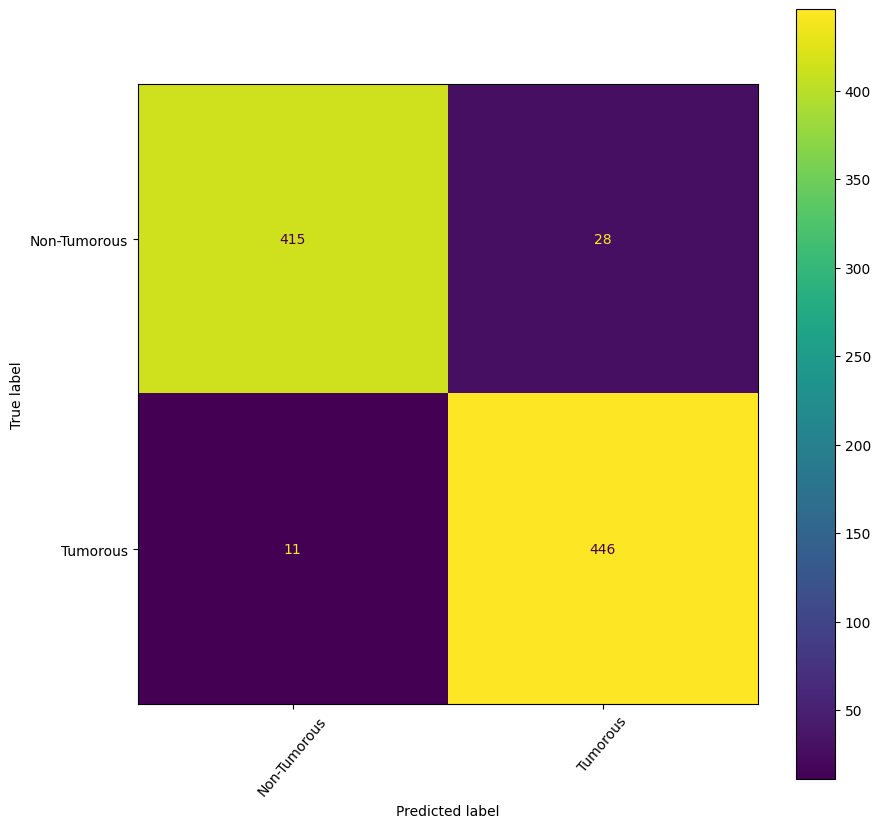

In [22]:
cm = tf.math.confusion_matrix(labels=df_test1['Actual1'].to_numpy(), predictions=df_test1['Pred1'].to_numpy()).numpy()
ls = ['Non-Tumorous', 'Tumorous'] # your y labels()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=50, ax = ax)
plt.show()

### Metrics

In [23]:
acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1]+ cm[1][1] + cm[1][0])
TPR =  (cm[1][1]) / (cm[1][1] + cm[1][0])
FPR = (cm[0][1]) / (cm[0][1] + cm[0][0])
print("ACC: {}\nTPR: {}\n FPR: {}".format(acc,TPR,FPR))

ACC: 0.9566666666666667
TPR: 0.975929978118162
 FPR: 0.06320541760722348


In [24]:
df_test1.head()

local_path Pred  Accurarcy Actual  \
0  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.031770     no   
1  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.858129     no   
2  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  92.561537     no   
3  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  99.993527     no   
4  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no  73.943019     no   

   Check  Pred1  Actual1  
0      1      0        0  
1      1      0        0  
2      1      0        0  
3      1      0        0  
4      1      0        0

In [25]:
df_test1[df_test1["Check"] == 0][['Actual',"Pred"]].value_counts()

Actual  Pred
no      yes     28
yes     no      11
dtype: int64

In [26]:
df_test1

local_path Pred   Accurarcy  \
0    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.031770   
1    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.858129   
2    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   92.561537   
3    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.993527   
4    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   73.943019   
..                                                 ...  ...         ...   
895  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
896  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes   99.991608   
897  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
898  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
899  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   

    Actual  Check  Pred1  Actual1  
0       no      1      0        0  
1       no      1      0        0  
2       no      1      0        0  
3       no      1      0        0  
4       no      1      0        0  
..     ...    ...    ...      ...  
895    yes      1      1        1  
896    yes      1      1        1  
897    yes      1      1        1  
898    yes      1      1        1  
899    yes      1      1        1  

[900 rows x 7 columns]

In [27]:
df_test2= df_test1.head(10)

In [28]:
df_test3= df_test1.tail(10)

In [29]:
df_test4 = pd.concat([df_test2,df_test3])

In [30]:
df_test4

local_path Pred   Accurarcy  \
0    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.031770   
1    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.858129   
2    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   92.561537   
3    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.993527   
4    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   73.943019   
5    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.999952   
6    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.999928   
7    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   98.905540   
8    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   81.934065   
9    /content/drive/My Drive/sihArohi/HTM/Arohi28oc...   no   99.137223   
890  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes   99.999762   
891  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
892  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
893  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
894  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
895  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
896  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes   99.991608   
897  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
898  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   
899  /content/drive/My Drive/sihArohi/HTM/Arohi28oc...  yes  100.000000   

    Actual  Check  Pred1  Actual1  
0       no      1      0        0  
1       no      1      0        0  
2       no      1      0        0  
3       no      1      0        0  
4       no      1      0        0  
5       no      1      0        0  
6       no      1      0        0  
7       no      1      0        0  
8       no      1      0        0  
9       no      1      0        0  
890    yes      1      1        1  
891    yes      1      1        1  
892    yes      1      1        1  
893    yes      1      1        1  
894    yes      1      1        1  
895    yes      1      1        1  
896    yes      1      1        1  
897    yes      1      1        1  
898    yes      1      1        1  
899    yes      1      1        1

<ipython-input-31-95156fad1593>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(img_path)


Actual: no 
Prediction: no


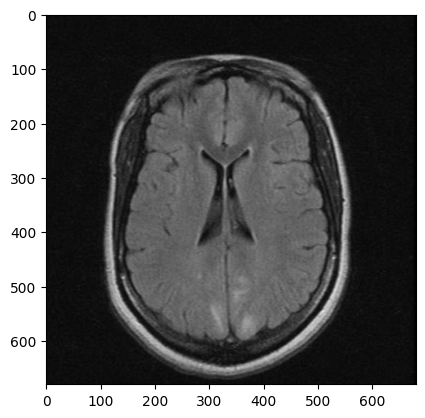

Actual: no 
Prediction: no


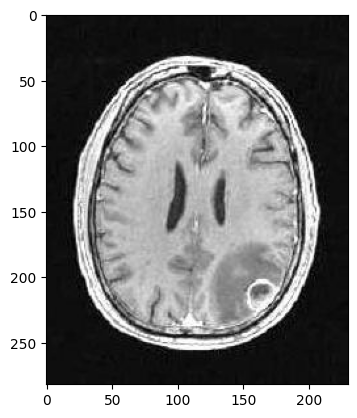

Actual: no 
Prediction: no


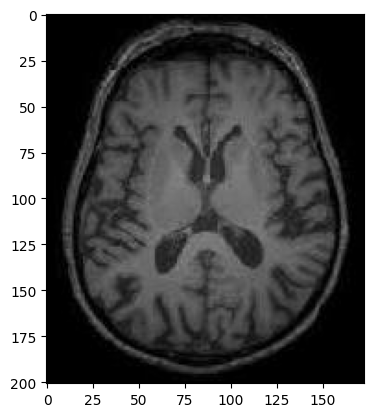

Actual: no 
Prediction: no


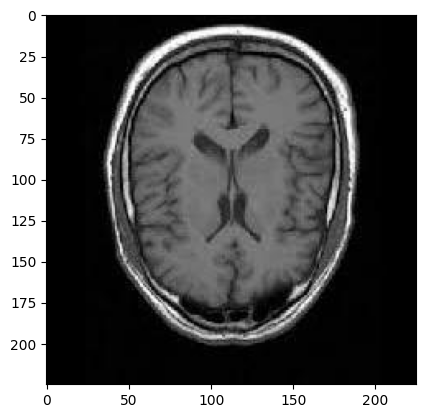

Actual: no 
Prediction: no


Actual: no 
Prediction: no


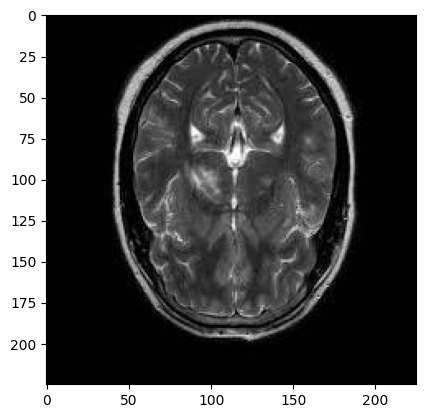

Actual: no 
Prediction: no


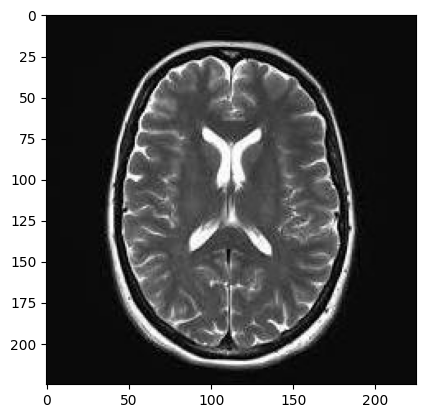

Actual: no 
Prediction: no


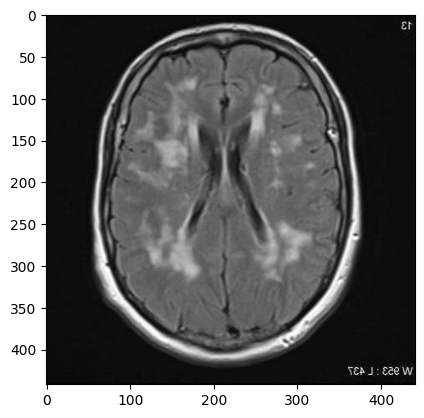

Actual: no 
Prediction: no


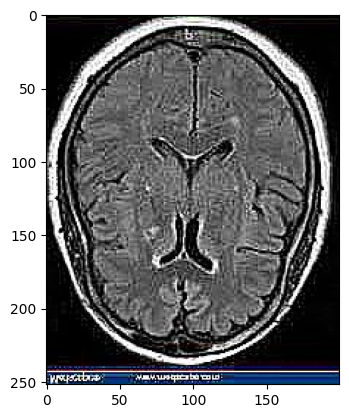

Actual: no 
Prediction: no


Actual: yes 
Prediction: yes


Actual: yes 
Prediction: yes


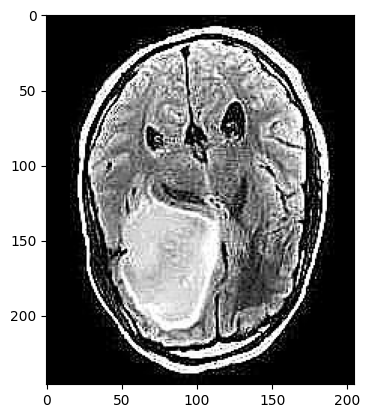

Actual: yes 
Prediction: yes


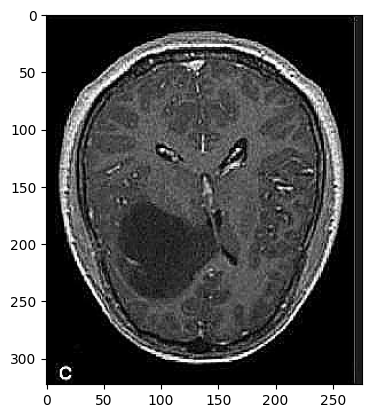

Actual: yes 
Prediction: yes


Actual: yes 
Prediction: yes


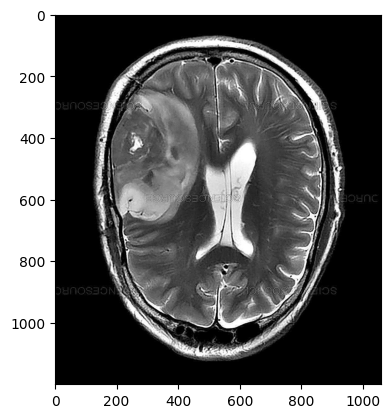

Actual: yes 
Prediction: yes


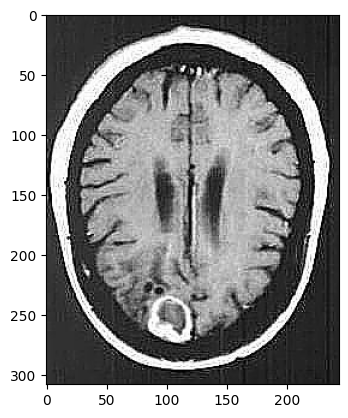

Actual: yes 
Prediction: yes


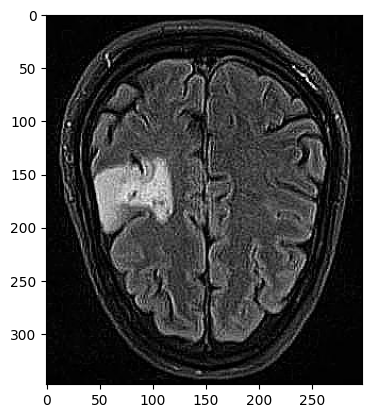

Actual: yes 
Prediction: yes


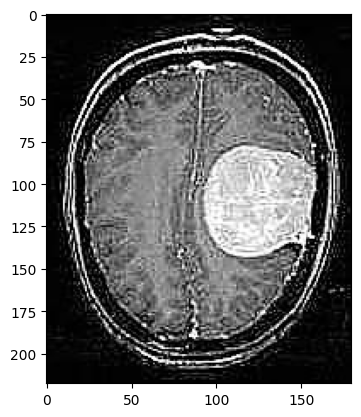

Actual: yes 
Prediction: yes


Actual: yes 
Prediction: yes


In [31]:
for a,b in df_test4.iterrows():
    img_path = (b['local_path'])
    im = imageio.imread(img_path)

    print("Actual: {} \nPrediction: {}".format(b['Actual'], b['Pred']))
    plt.imshow(im)
    plt.show()
    print('==============================================')

In [33]:
model.save("Copy of HTM_AROHI.ipynb")